# Constraints on momentum

## "Barrier" constraint

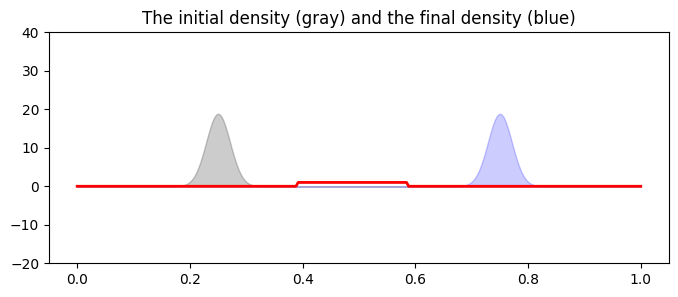

In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / (256)

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 40)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
H = np.zeros((K,))
H[100:150] = 1.0
plt.plot(X, H, color="r", lw=2, label="H(x)")

In [8]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.stack([H] * T, axis=0)  # Repeating H for each time step
time = np.array([(i+0.5)/T for i in range(0,T)])

xs = []

# Wasserstein
#x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=0.0, #delta=0.5/np.pi, niter=3000)
#xs.append(x)

delta = 2.0

# Wasserstein-Fisher-Rao
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

# momentum is less than 0
Hs = [np.zeros((T, K)), H, np.zeros((T, K))]
GL = np.ones((T,)) * (-np.inf)
GU = np.ones((T,)) * 0.1
x, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
xs.append(x)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


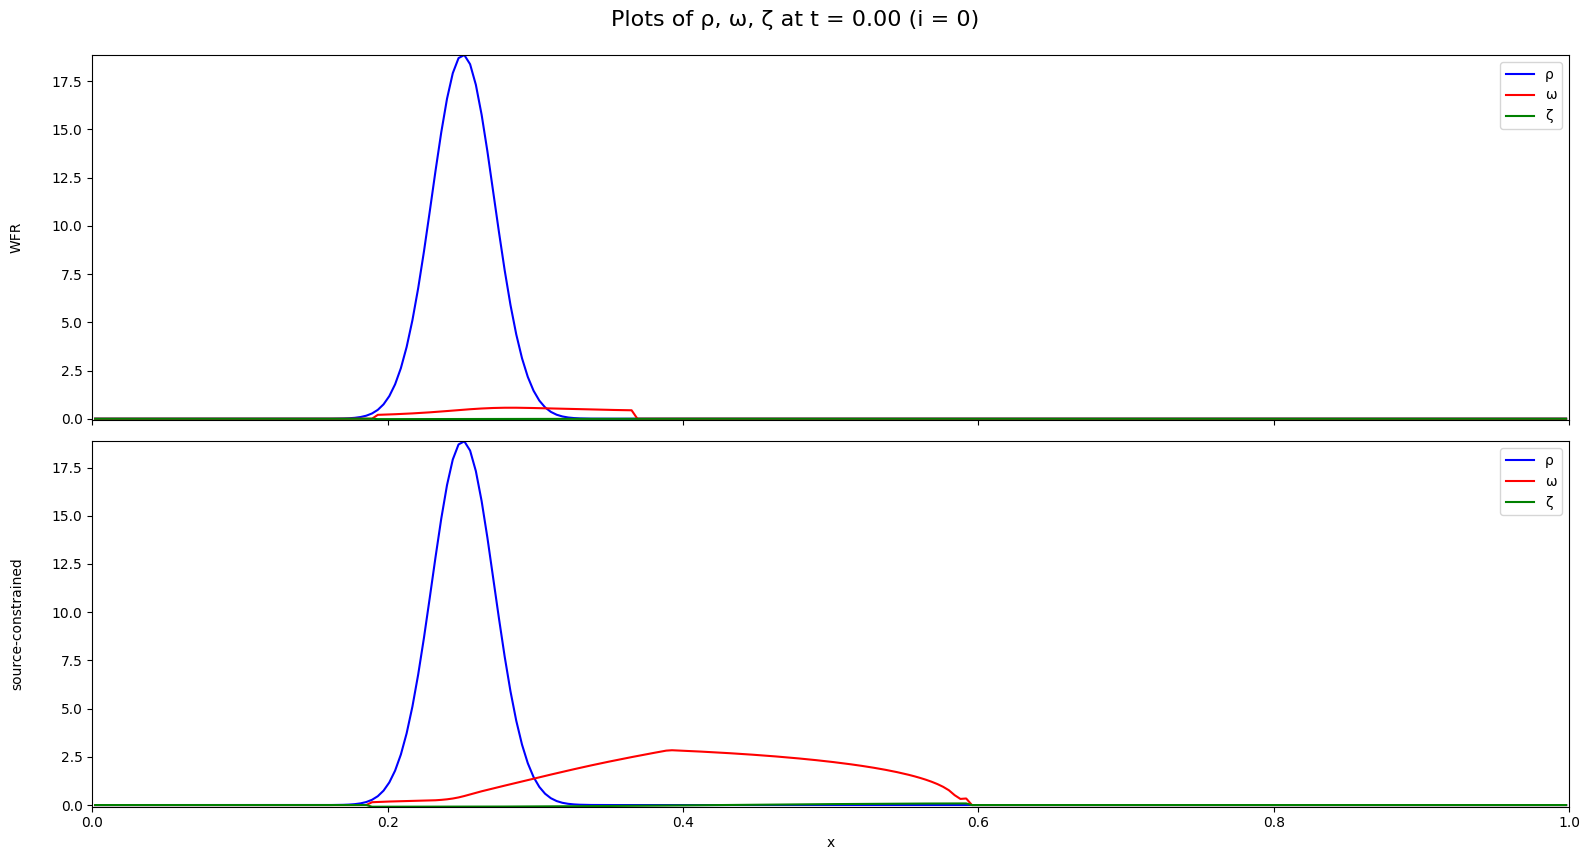

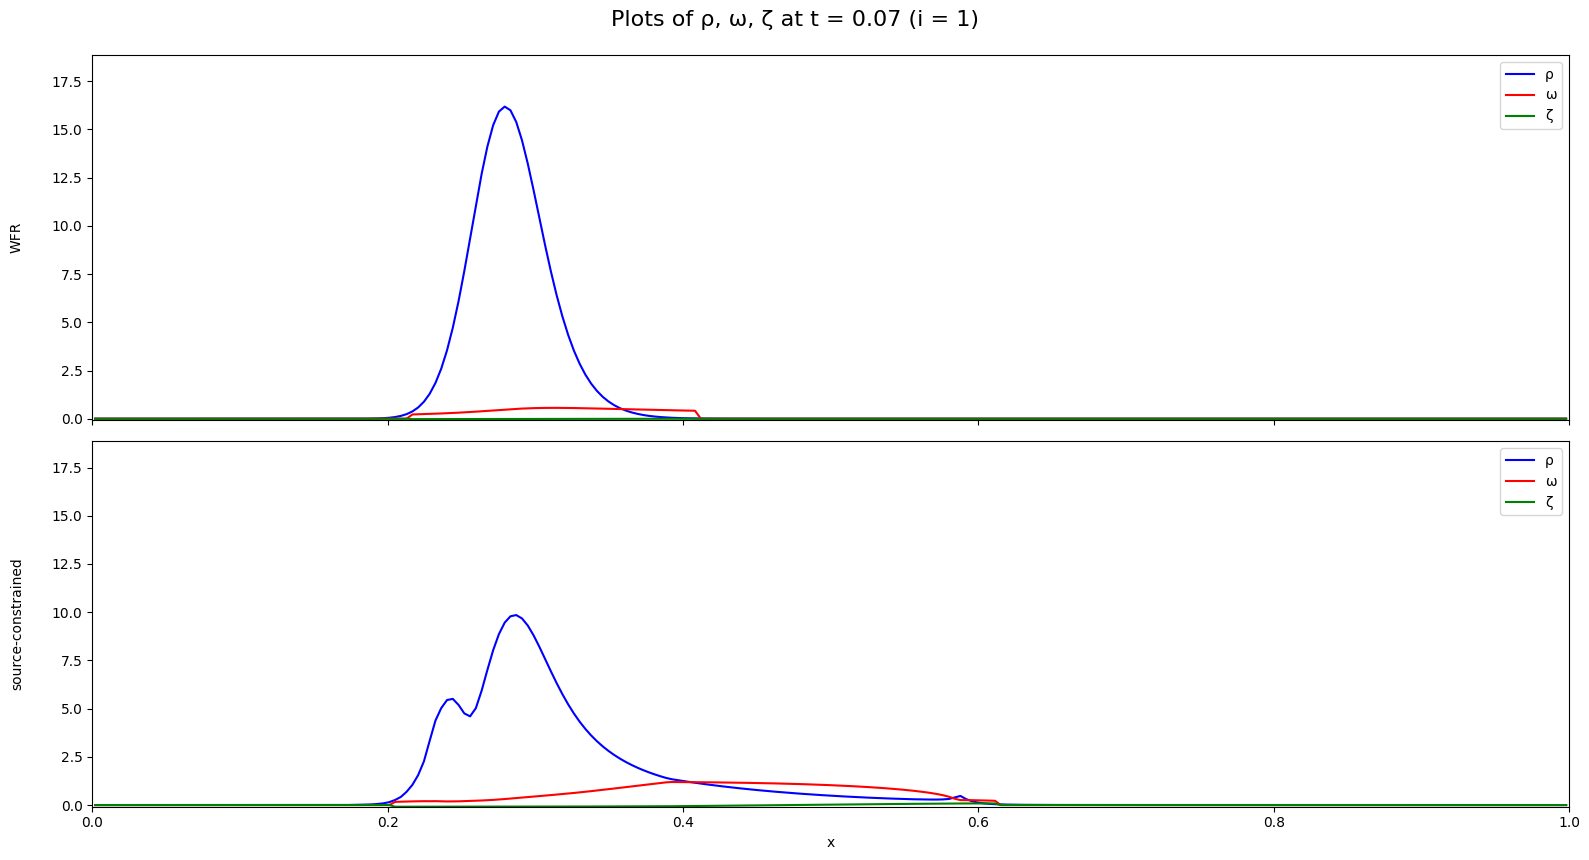

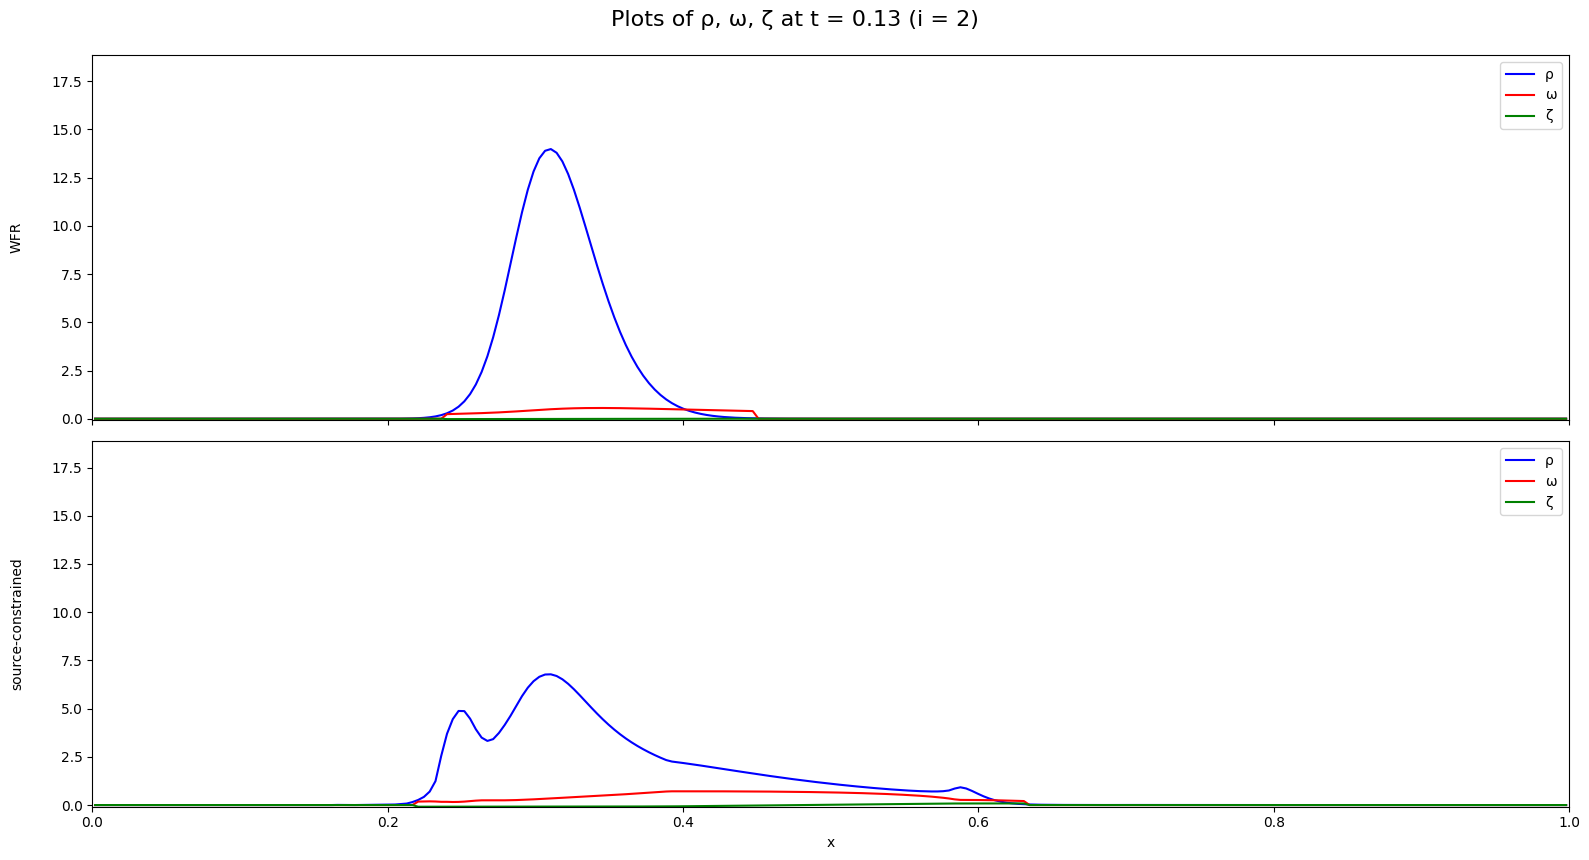

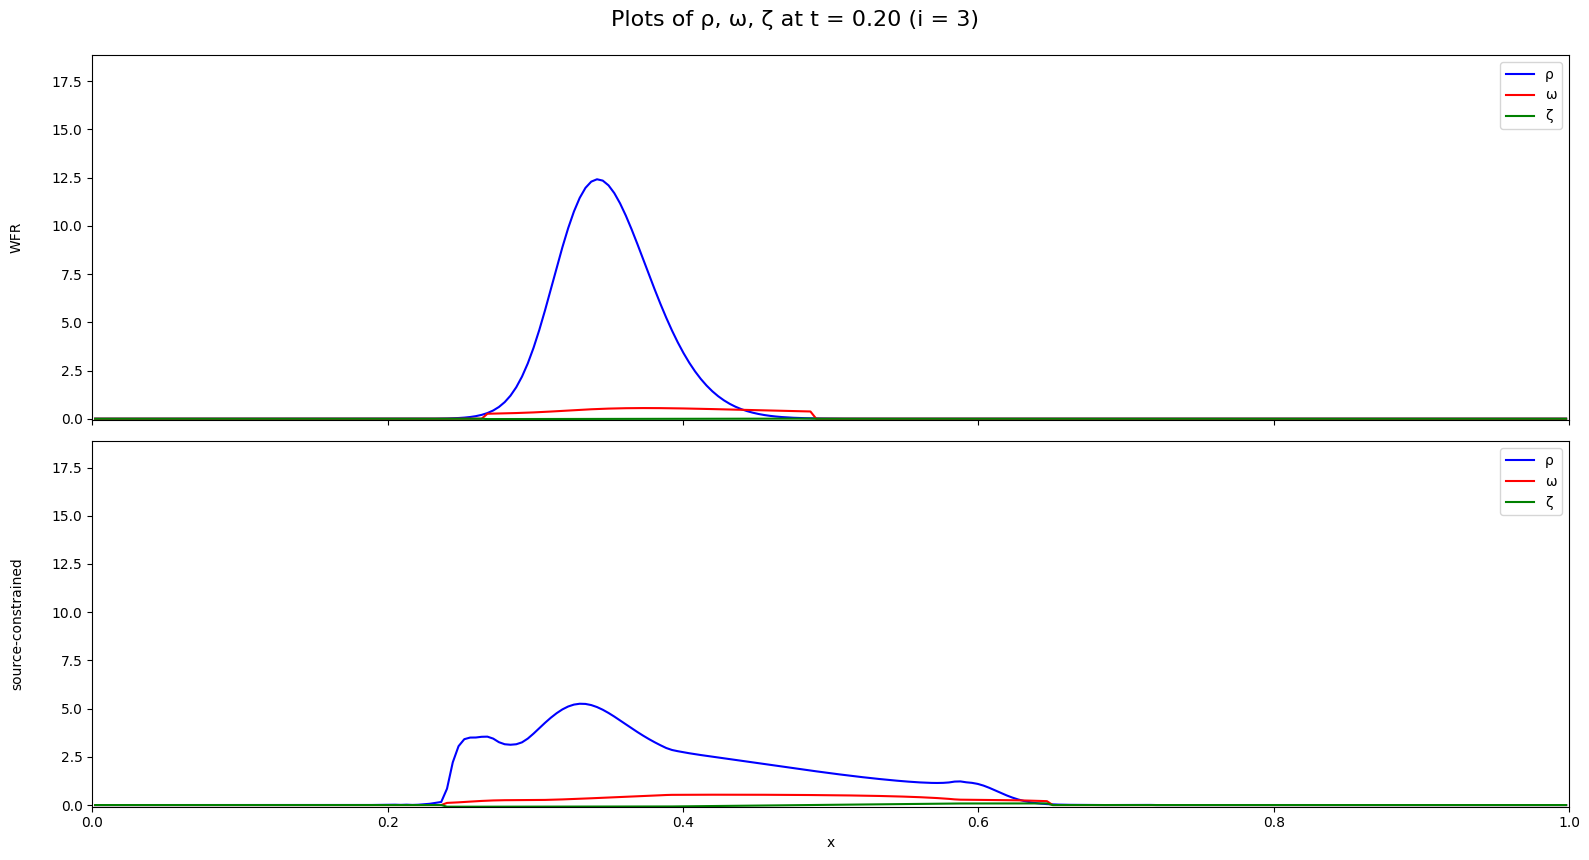

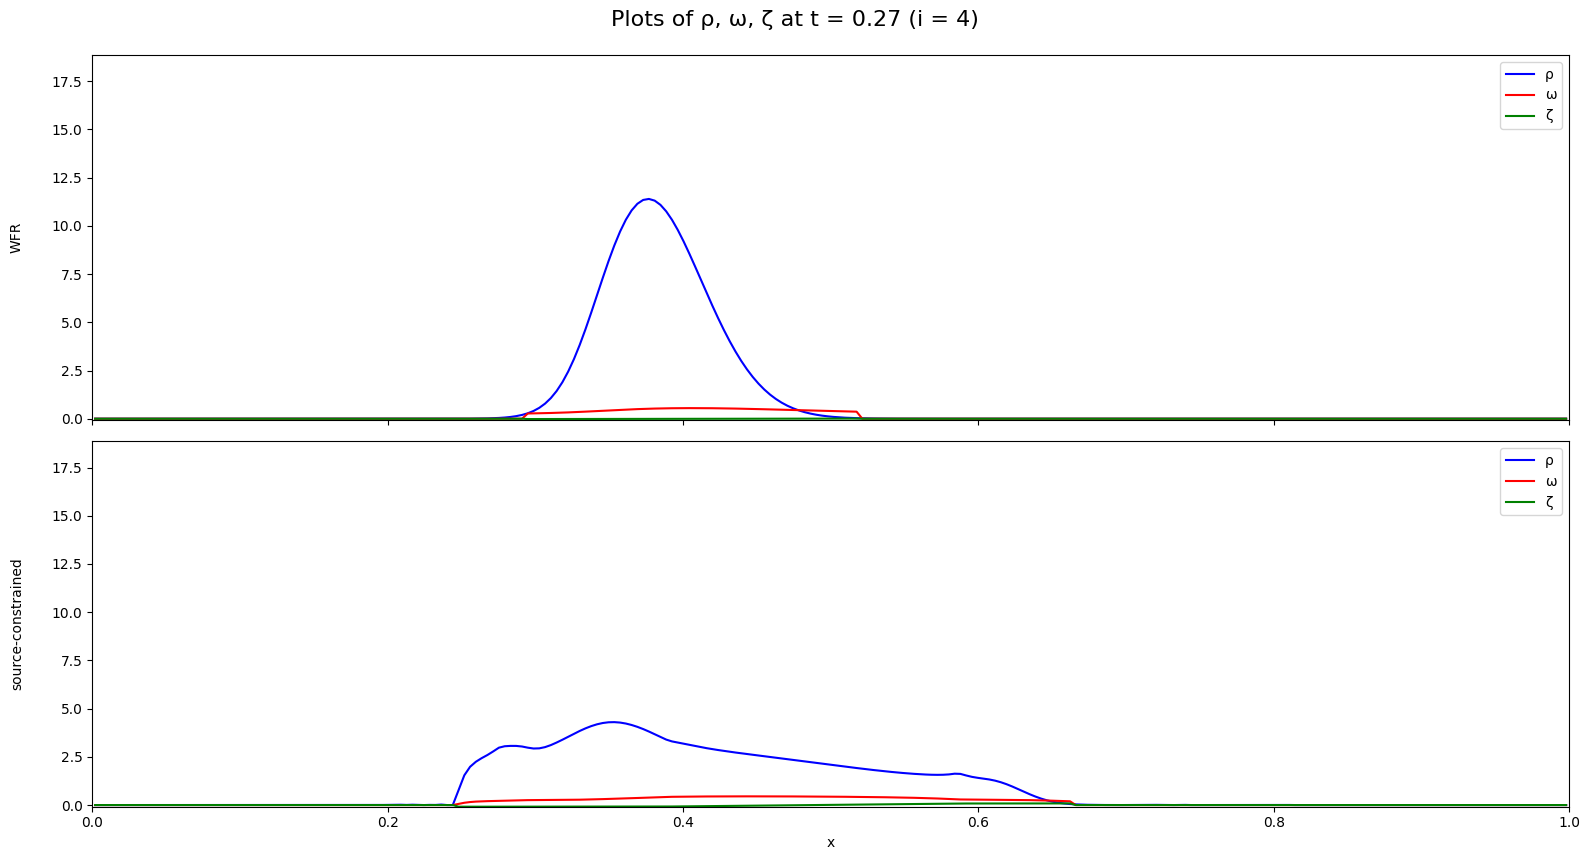

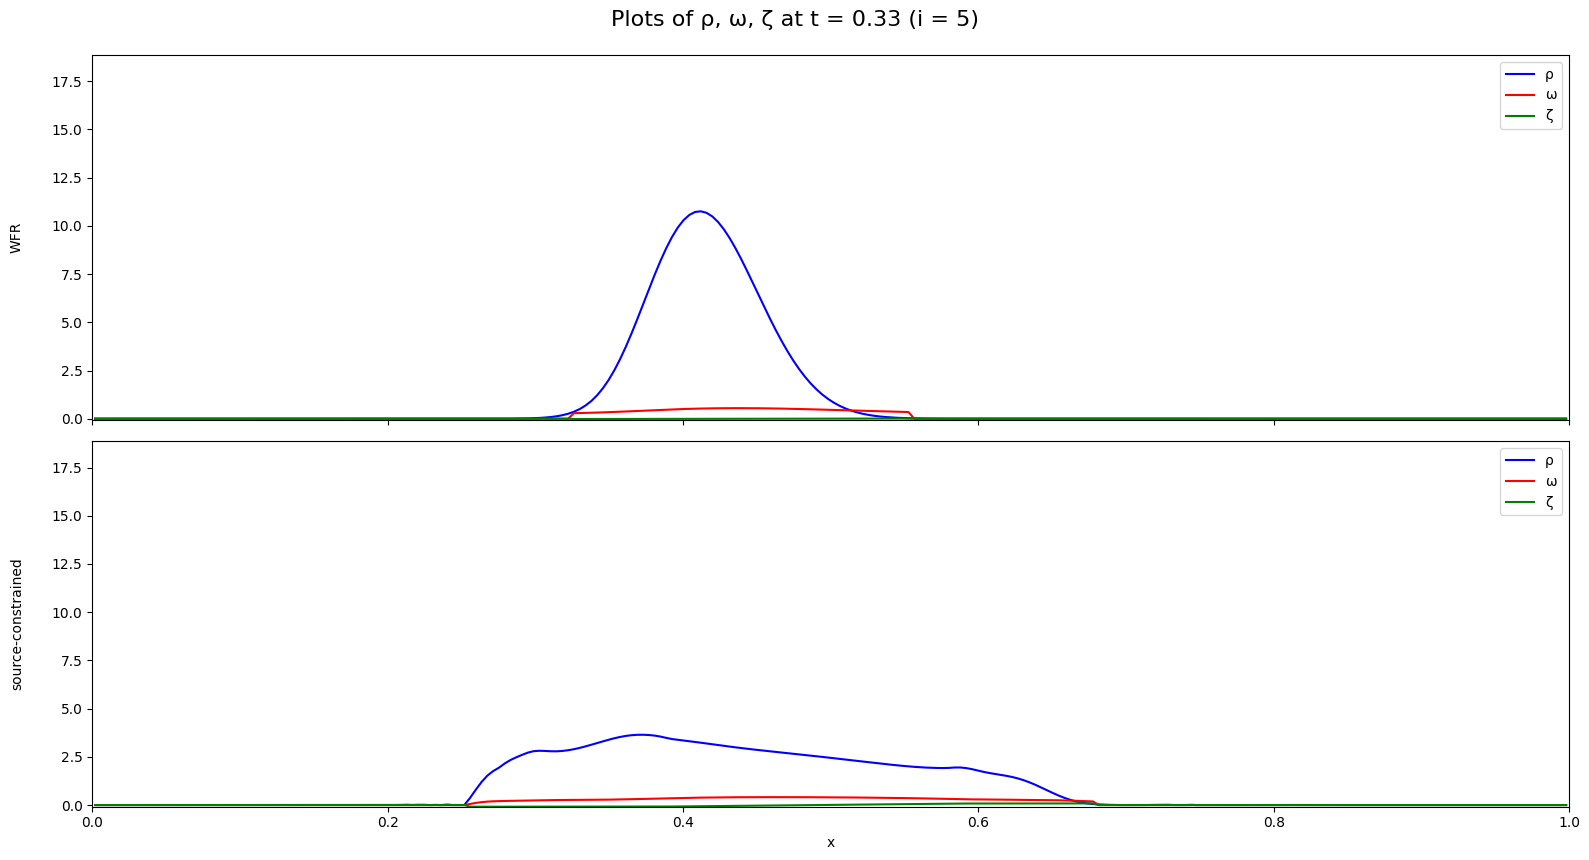

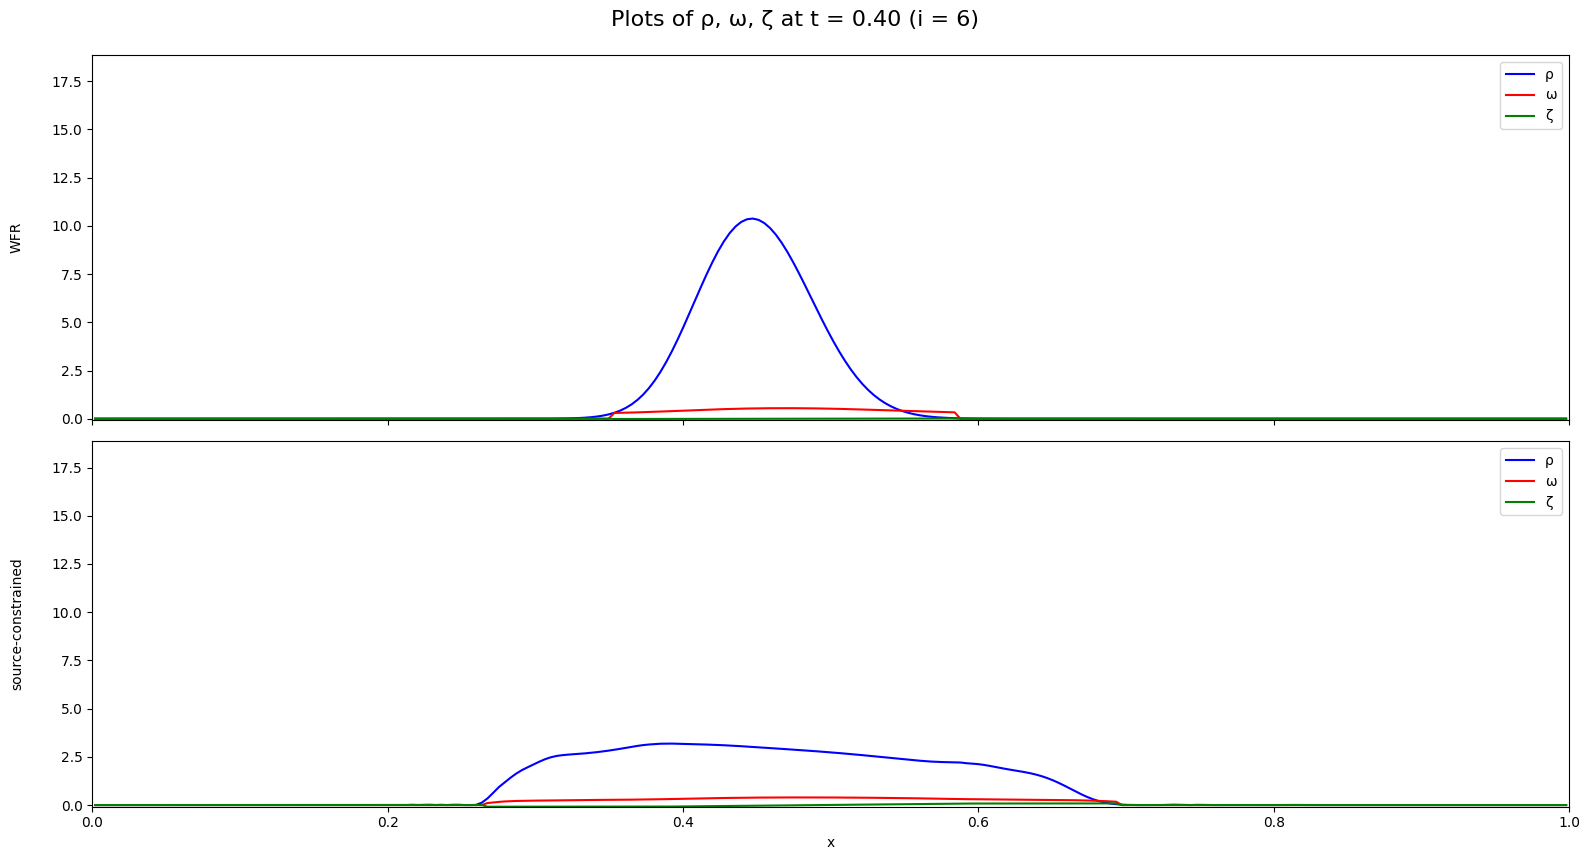

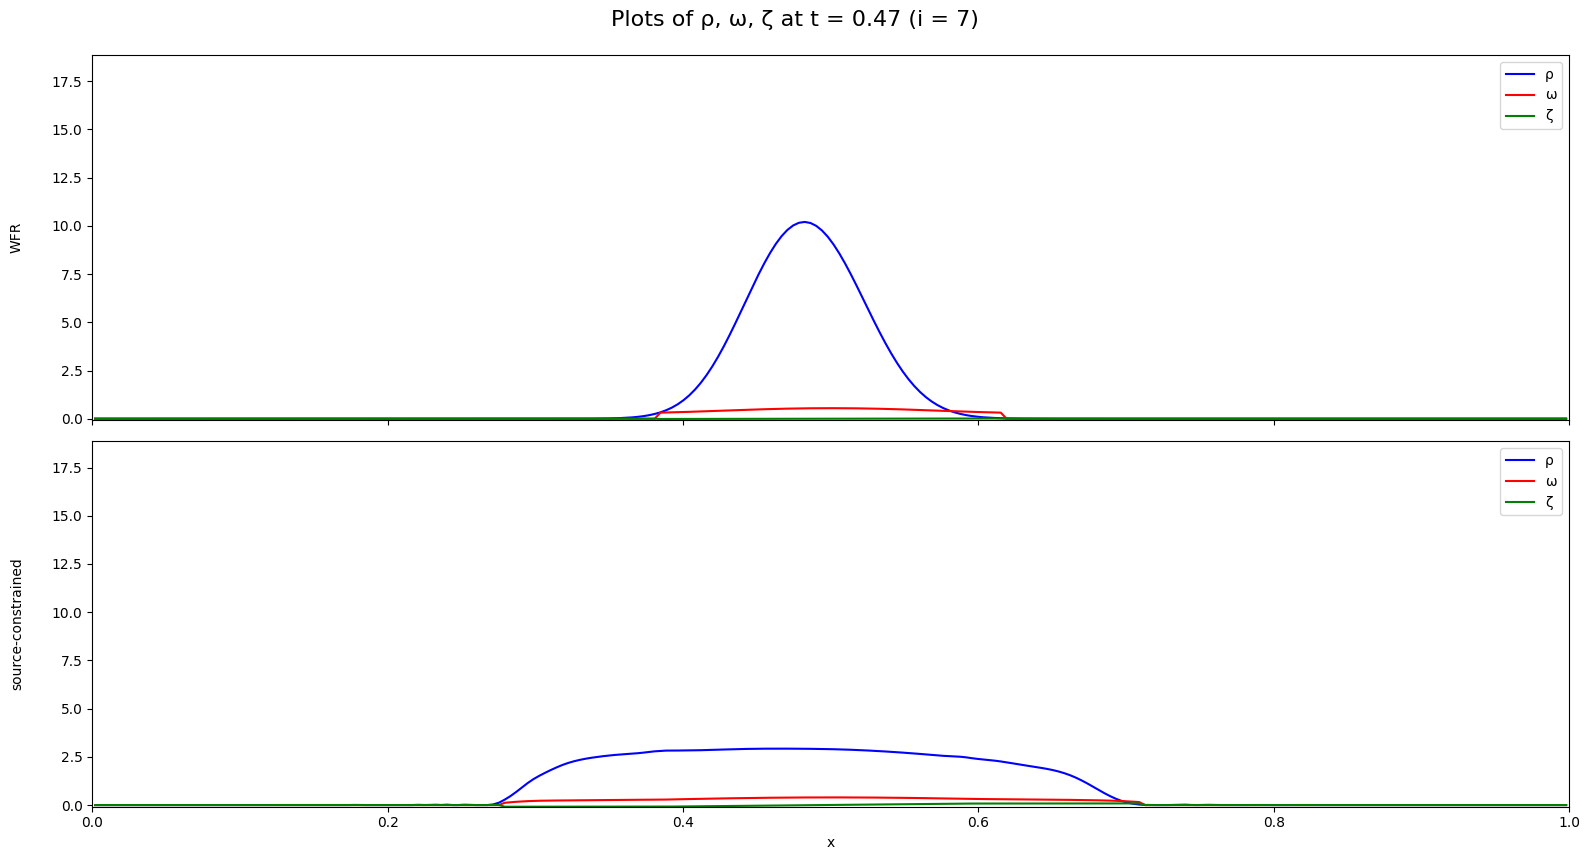

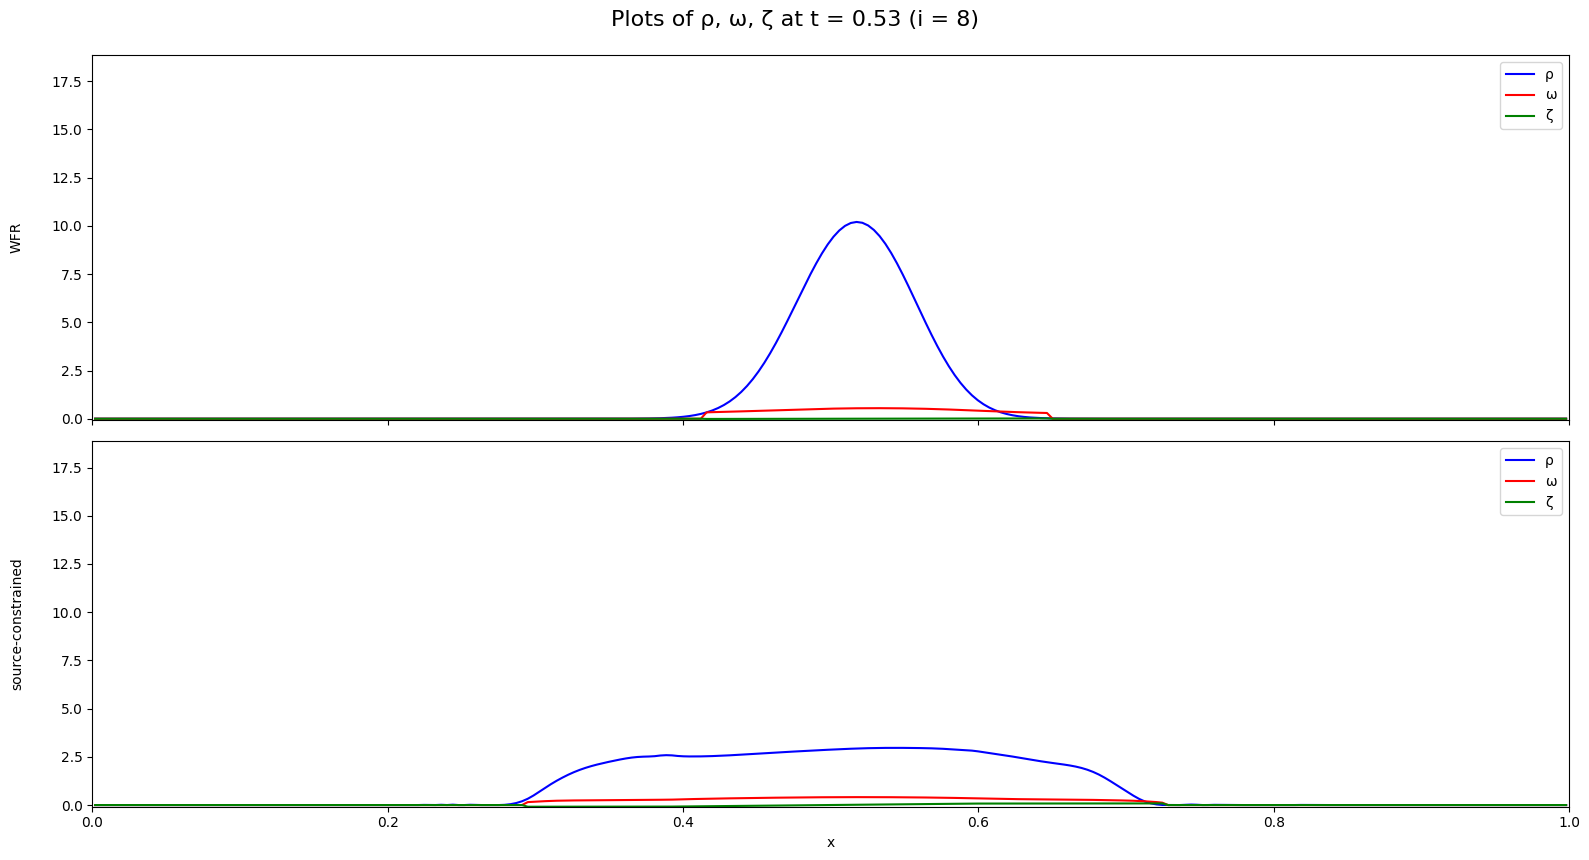

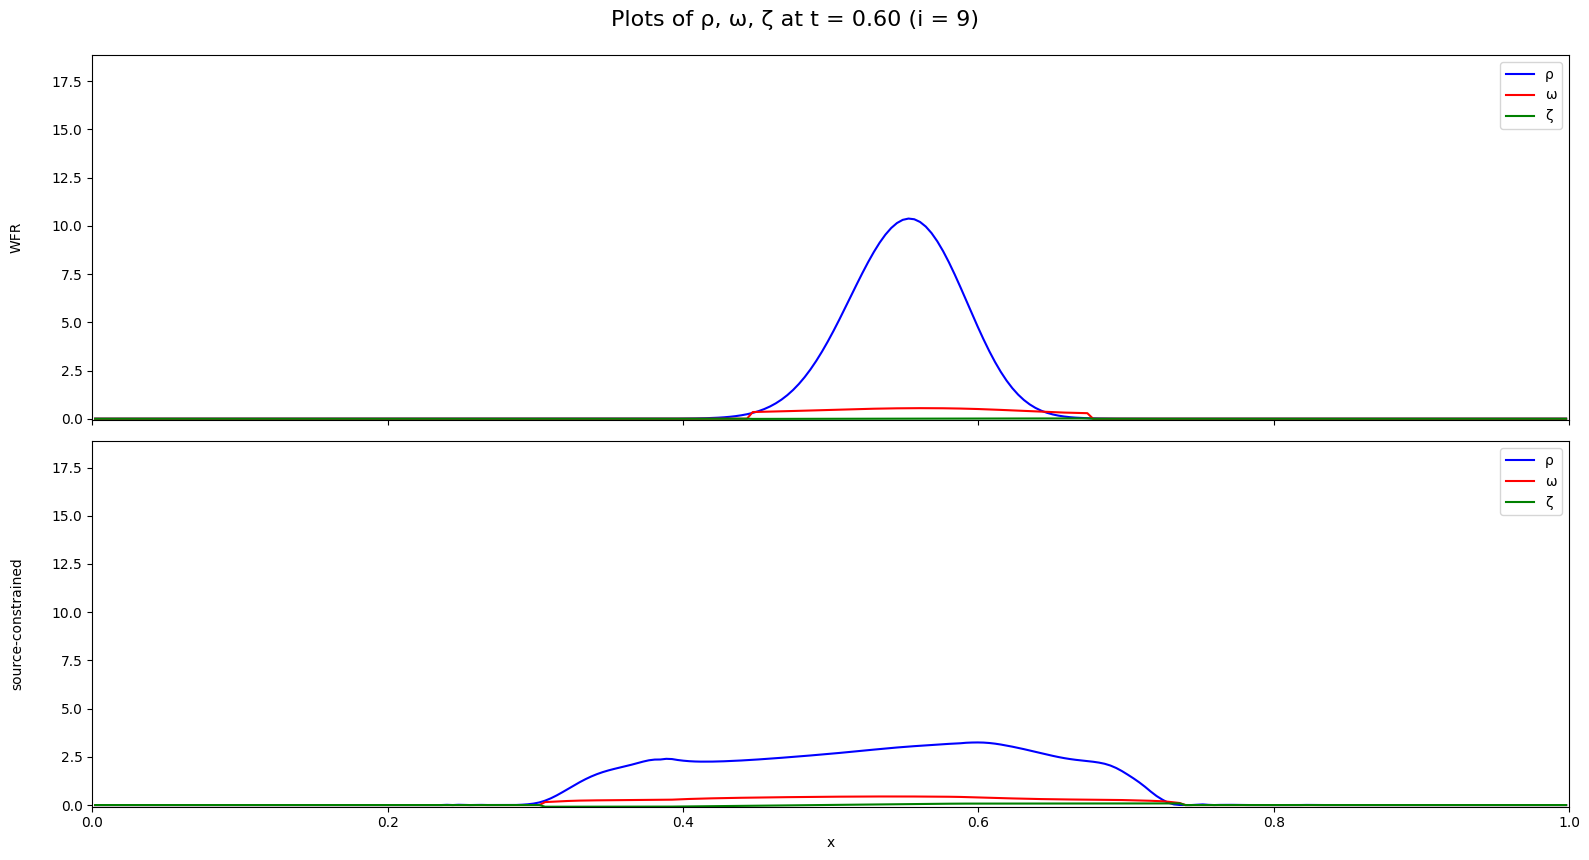

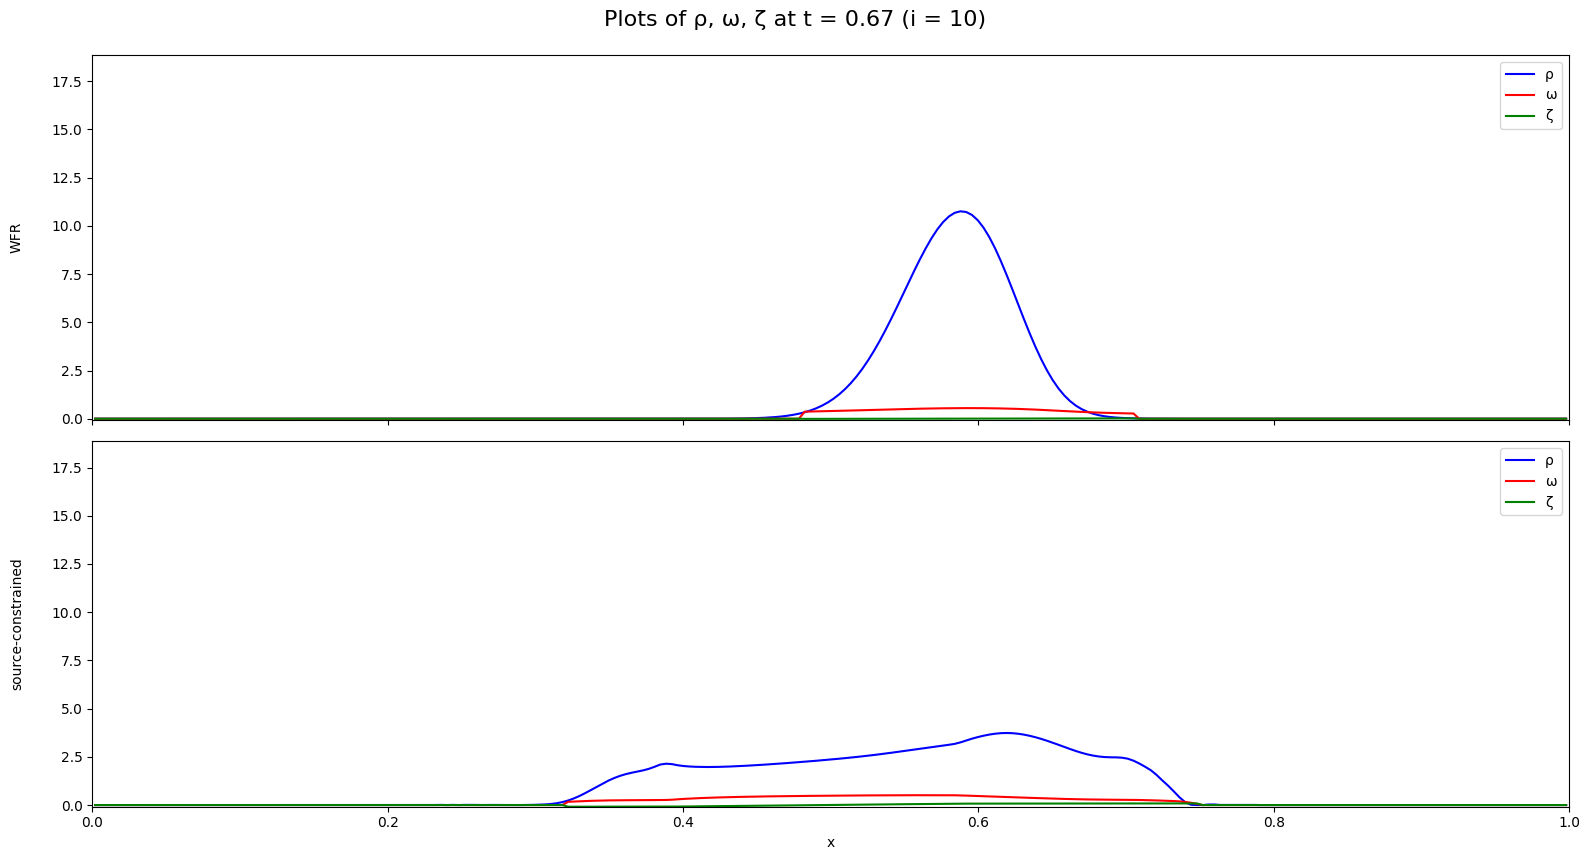

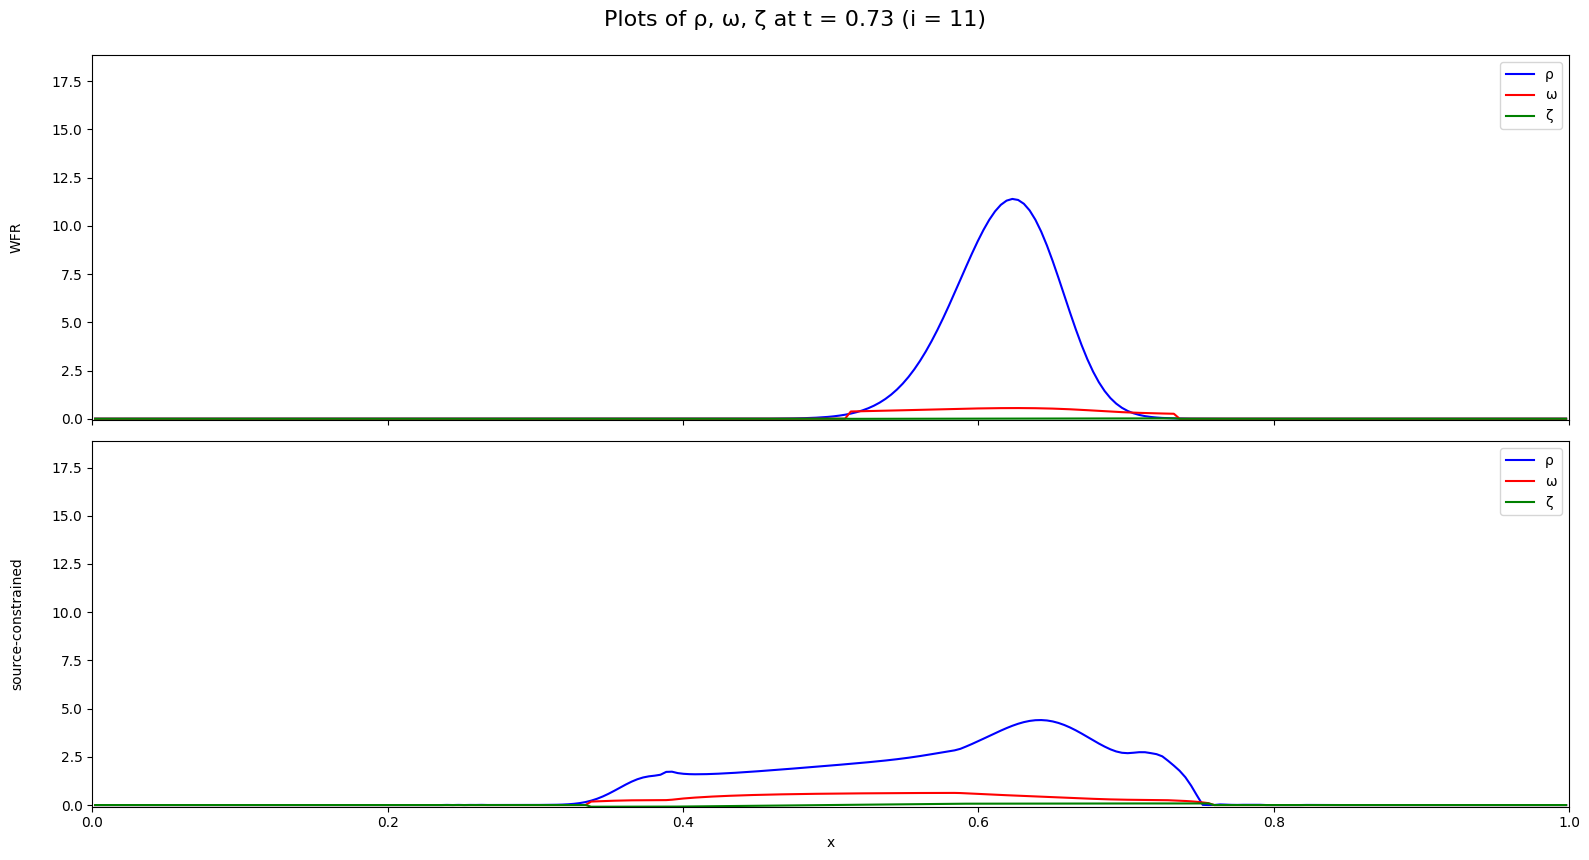

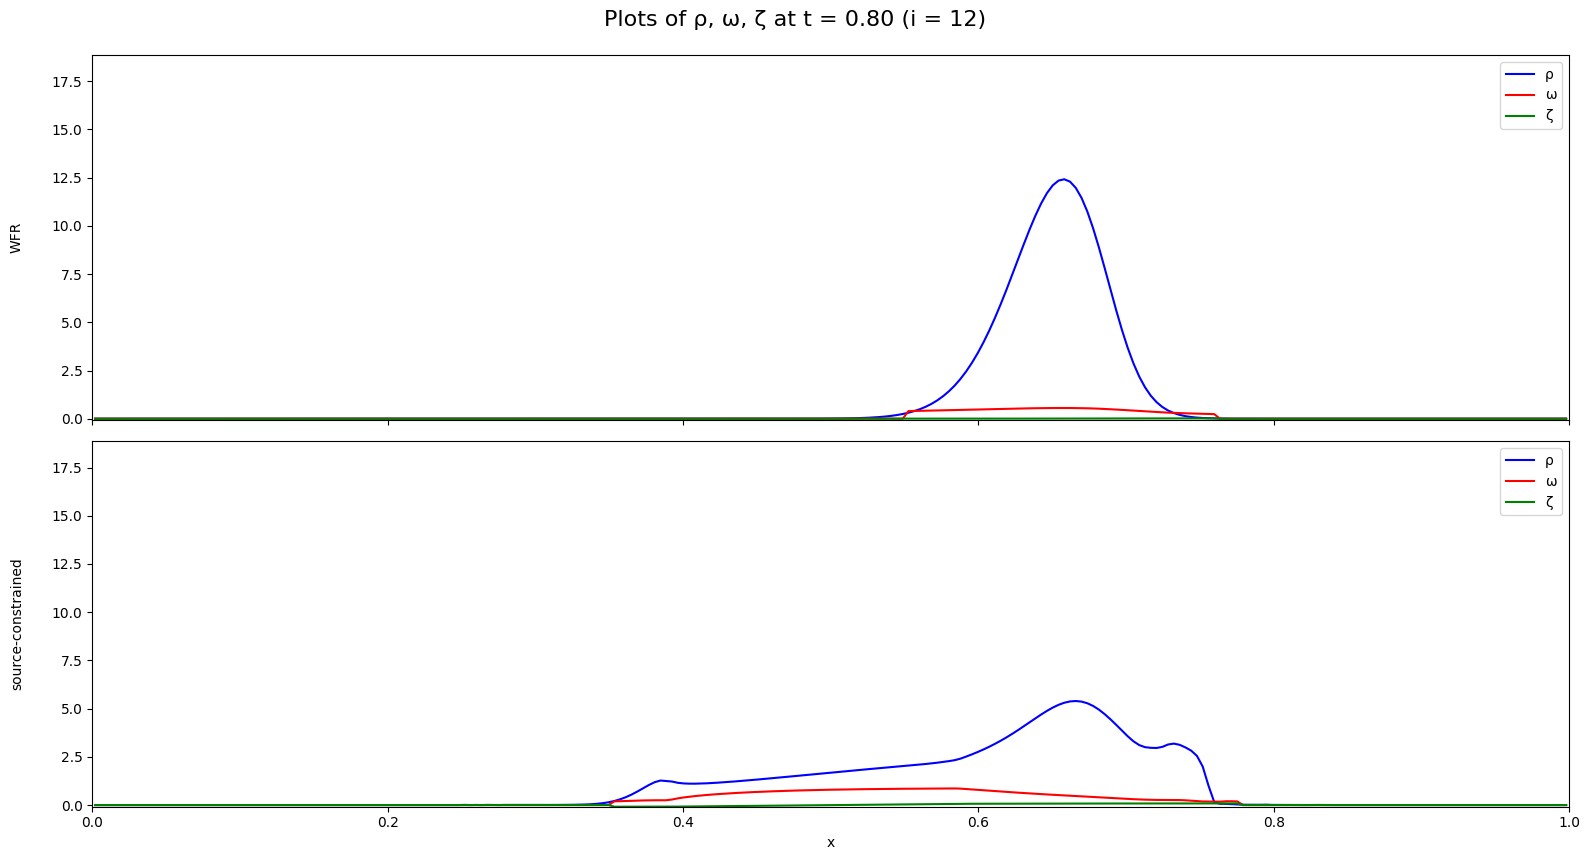

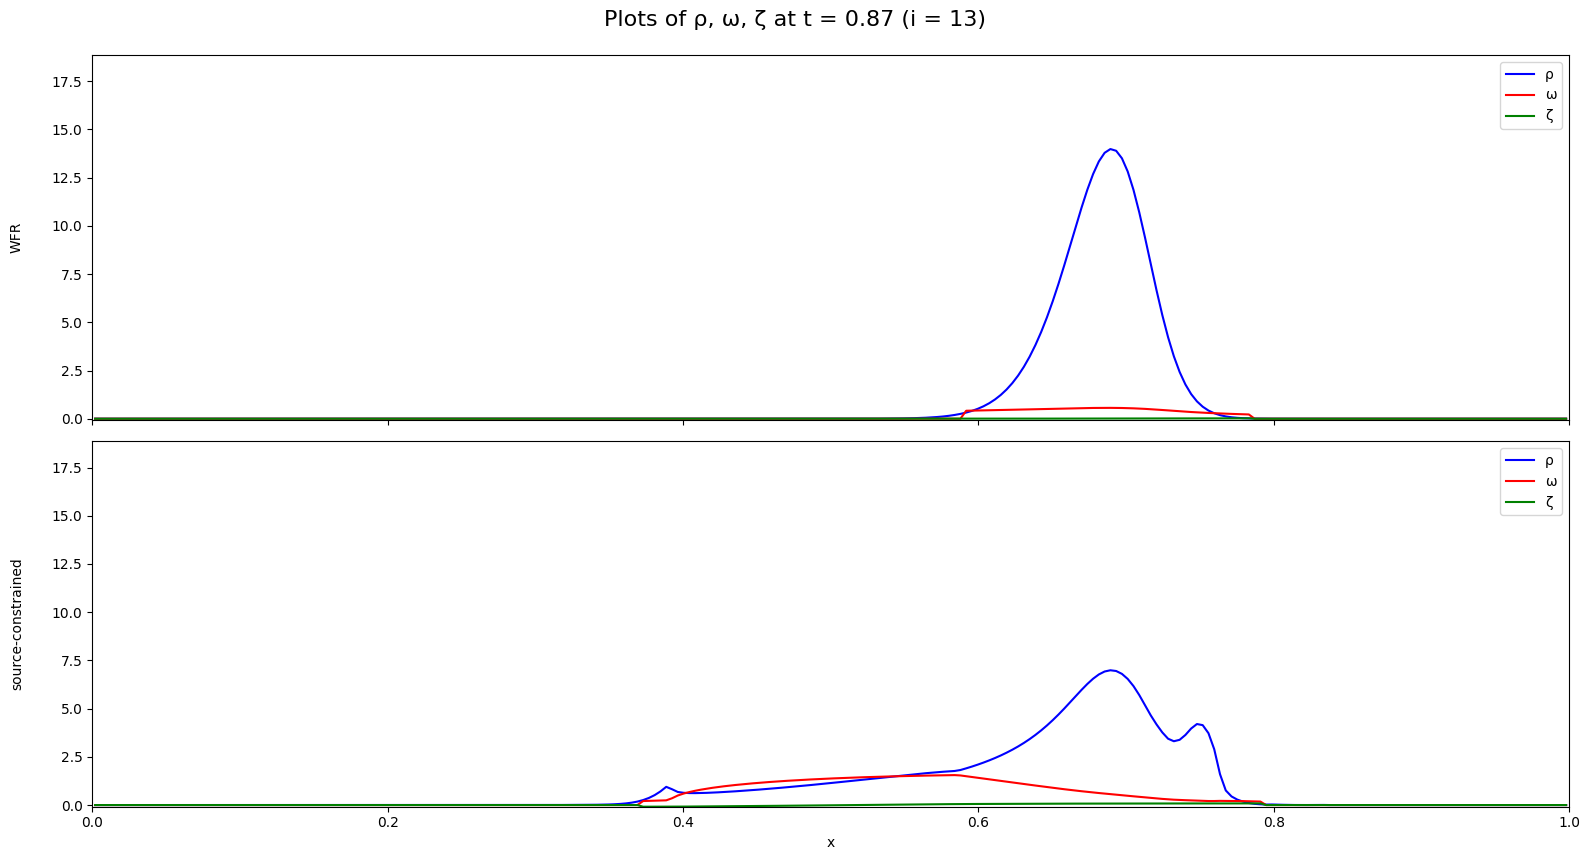

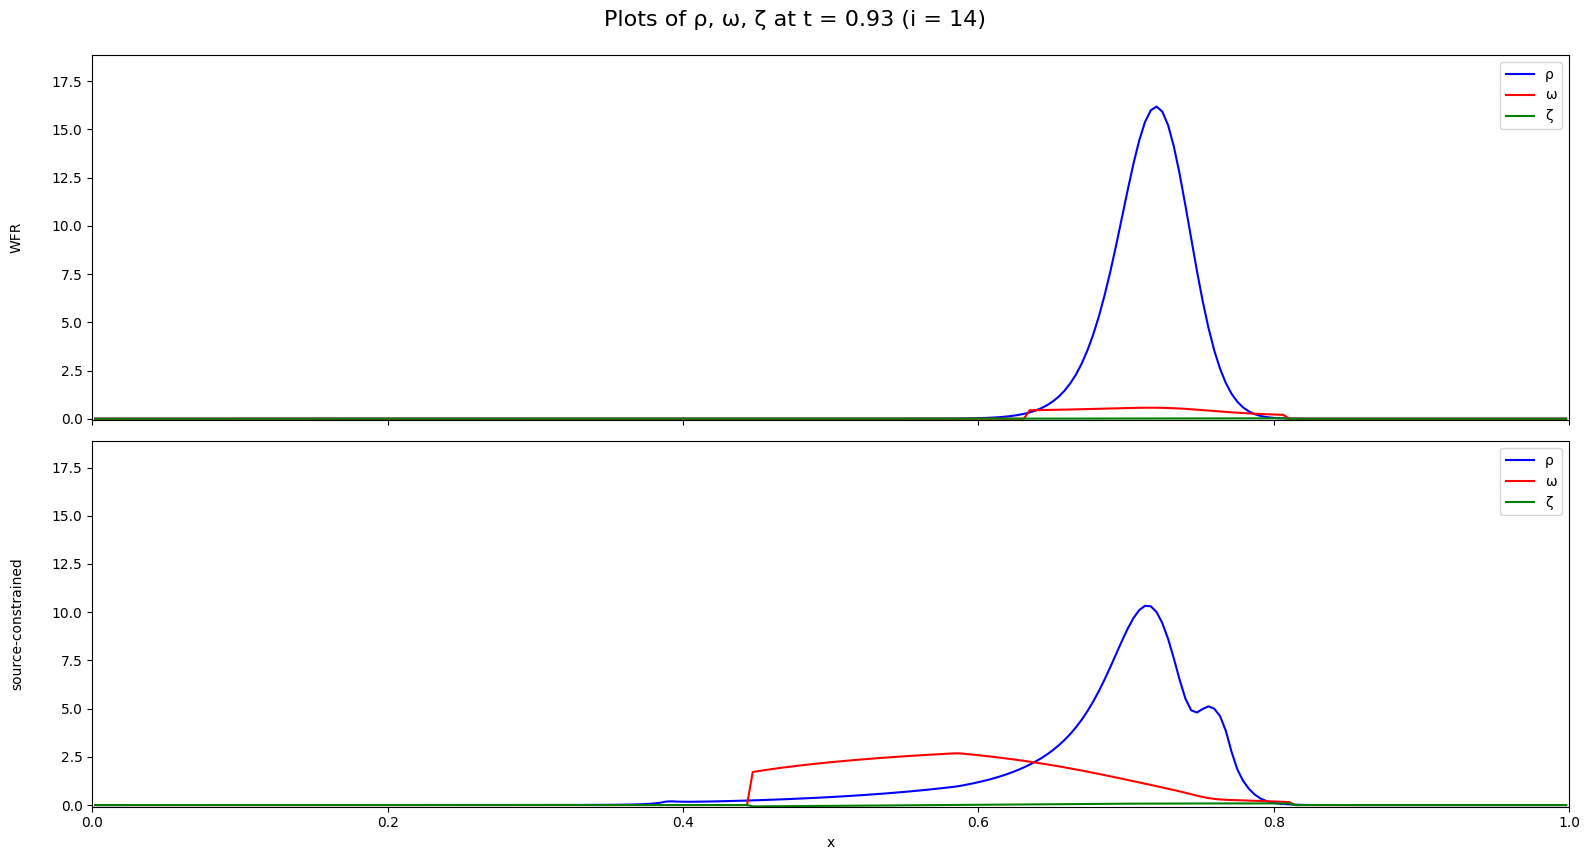

In [9]:
import numpy as np
import matplotlib.pyplot as plt

Ds = []
vs = []
gs = []
for x in xs:
    Ds.append(x.U.D[0])
    v, g = speed_and_growth(x.V, 100)
    vs.append(v[0])
    gs.append(g)

# Time and space grids
t = np.linspace(0, 1, 16)             # t_i = i/15
x_grid = (np.arange(256) + 0.5) / 256 # x_j = (j+0.5)/256

# Row labels
row_labels = ["WFR", "source-constrained"]

# Indices of time to plot
time_indices = list(range(15))

# -----------------------------------------------------------
# 2) Compute global min/max for each row across *all times*
#    and across D, v, and g. This ensures fixed y-limits.
# -----------------------------------------------------------
num_rows = len(row_labels)
min_vals = float('inf')
max_vals = float('-inf')

for row in range(num_rows):
    # Flatten or just use min/max on the entire 16x256 data
    # across D, v, and g for row 'row'
    row_min = min(Ds[row].min(), vs[row].min(), gs[row].min())
    row_max = max(Ds[row].max(), vs[row].max(), gs[row].max())
    
    min_vals = min(row_min, min_vals)
    max_vals = max(row_max, max_vals)

# -----------------------------------------------------------
# 3) Loop through the selected time indices and plot
# -----------------------------------------------------------
for i in time_indices:
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(16, 9), sharex=True)
    
    # Main figure title
    fig.suptitle(f"Plots of ρ, ω, ζ at t = {t[i]:.2f} (i = {i})", fontsize=16, y=0.95)

    for row in range(num_rows):
        ax = axes[row]
        
        # Plot all three on the same axes
        ax.plot(x_grid, Ds[row][i, :], label='ρ', color='blue')
        ax.plot(x_grid, vs[row][i, :], label='ω', color='red')
        ax.plot(x_grid, gs[row][i, :], label='ζ', color='green')
        
        # Set fixed y-limits for this row
        ax.set_ylim([min_vals, max_vals])
        
        # Set x-limits if desired (0 to 1 here)
        ax.set_xlim([0, 1])

        # Label the y-axis to indicate the row
        ax.set_ylabel(row_labels[row], rotation=90, labelpad=20)
        
        # Show legend in each subplot
        ax.legend(loc='best')
    
    # Label the x-axis on the bottom subplot
    axes[-1].set_xlabel("x")
    
    # Final layout adjustments
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

## 2D 

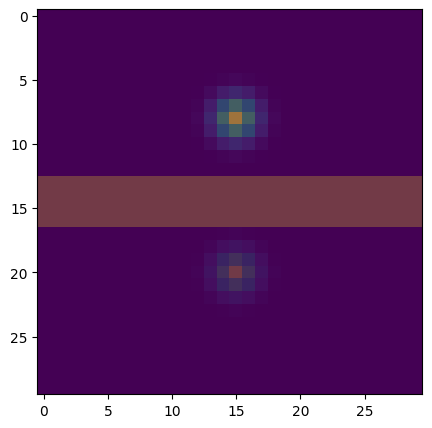

In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image


maze = np.zeros((30, 30))
maze[13:17, 0:30] = 1

T = 15
N1 = maze.shape[0]
N2 = maze.shape[1]

H1 = np.repeat(maze[np.newaxis, :, :], T, axis=0) * np.cos(np.pi / 4)
H2 = np.repeat(maze[np.newaxis, :, :], T, axis=0) * np.sin(np.pi / 4)
#H = np.repeat(maze[np.newaxis, :, :], T, axis=0)  # Repeating maze for each time step
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 20./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 8./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

In [11]:
T = 15 # number of time steps
ll = (1.0, 1.0, 1.0) # size of time x space box

xs = []

# Wasserstein
#x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=0.0, #delta=0.5/np.pi, niter=3000)
#xs.append(x)

delta = 2.0

# Wasserstein-Fisher-Rao
x1, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)


#Hs = [np.zeros((T, 30, 30)), H1, H2, np.zeros((T, 30, 30))]
Hs = [np.zeros((T, N1, N2)), H1, H2, np.zeros((T, N1, N2))]
GL = np.zeros((T,))  
GU = np.ones((T,)) * np.inf
x2, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
#xs.append(x)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


In [ ]:
def plot_maze_1(t, x, maze, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(rho_0)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(rho_1)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(x.V.D[0][t])
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    ax1.imshow(maze, alpha=0.5)

    plt.show()

plot_elements5 = [x1.copy(), maze.copy(), xx, yy, rho_0.copy(), rho_1.copy()]
interact(lambda t: plot_maze_1(t, *plot_elements5), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

In [ ]:
plot_elements6 = [x2.copy(), maze.copy(), xx, yy, rho_0.copy(), rho_1.copy()]
interact(lambda t: plot_maze_1(t, *plot_elements6), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>